In [1]:
## This is the code to do quick analysis of Ale's spreadsheets, to help look for trends
# December 4, 2025
#
# Step 1.) Make a list of all the spreadsheets in each experiemental condition
# Step 2.) Group the files by the cellpose size that was used in detection
# Step 3.) For each gut, create a new table with the voxels scaled by actual size, remove any object smaller than 200 um^3 
# Step 4.) Plot the distribution of the cell sizes in each gut, and grouped by condition, cut off the top X% where X is going to be later figured out
# Step 5.) Get some summary stats for each condition.  Average number of cells per gut (with std error bars), average cell size (with std error bars)
# Step 6.) Save.


In [2]:
import sys
import numpy as np
import pandas as pd
import os

import matplotlib
#matplotlib.rcParams["image.interpolation"] = 200
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread

from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table

import traceback

In [3]:
gceRNAi_data ="/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/gceRNAi/"
mated_data = "/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/mated/"
virgin_data = "/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/virgin/"
save_dir = "/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/"
pixel_sizes = [10, 15, 20] #the pixel sizes we used in cellpose
extension = ".csv" #the file extension of the data files
x_size = 0.7576 #um
y_size = 0.7576 #um
z_size = 1 #um (it's 1.0007 but 7 angstroms seems a bit of a stretch)
vox_to_um = x_size*y_size*z_size

In [4]:
##TODO write a function that checks if the folders exist

In [5]:
# find files 
def find_data_files(root_folder, px_string, extension):
    data_files= []
    for dirpath, _, filenames in os.walk(root_folder):
        for fname in filenames:
            if px_string in fname.lower() and fname.lower().endswith(extension):
                full_path = os.path.join(dirpath, fname)
                data_files.append(full_path)
    return data_files

In [6]:
px_strings = [str(x) + "_pixels" for x in pixel_sizes]
px_strings

['10_pixels', '15_pixels', '20_pixels']

In [7]:
#Step 2: Get the results, grouped by cellpose size
gceRNAi_results = {}
for px in px_strings:
    key = f"gceRNAi_{px}"
    gceRNAi_results[key] = find_data_files(gceRNAi_data, px, extension)

virgin_results = {}
for px in px_strings:
    key = f"virgin_{px}"
    virgin_results[key] = find_data_files(virgin_data, px, extension)

mated_results = {}
for px in px_strings:
    key = f"mated_{px}"
    mated_results[key] = find_data_files(mated_data, px, extension)

In [8]:
#mated_results

In [9]:
# Step 3.) For each gut, create a new table with the voxels scaled by actual size, remove any object smaller than 200 um^3 
mated_results["mated_10_pixels"]

['/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/mated/gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3_masked/gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3_masked_10_pixels_segmentationr.csv',
 '/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/mated/gdctrlqf6mated2_lif___TileScan_2_R_1_Merged_1_1_masked/gdctrlqf6mated2_lif___TileScan_2_R_1_Merged_1_1_masked_10_pixels_segmentationr.csv',
 '/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/mated/gdcomtrolmated_lif___TileScan_1_R_44_Merged_1_1_masked/gdcomtrolmated_lif___TileScan_1_R_44_Merged_1_1_masked_10_pixels_segmentationr.csv',
 '/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/mated/gdcomtrolmated_lif___TileScan_1_R_11_Merged_1_1_masked/gdcomtrolmated_lif___TileScan_1_R_11_Merged_1_1_masked_10_pixels_segmentationr.csv',
 '/camp/ho

In [10]:
df = pd.read_csv(mated_results["mated_10_pixels"][0])

In [11]:
df.head()

,Unnamed: 0,label,area,x,y,z
0,0,1,561.0,2.837790,1275.402852,1956.513369
1,1,2,2729.0,7.794430,2420.238549,2179.635031
2,2,3,3923.0,9.998980,2399.310477,2190.349477
3,3,4,449.0,4.708241,1885.505568,2137.610245
4,4,5,530.0,1.871698,1303.909434,1944.920755


In [12]:
#let's write the functions to do some scaling
def scale_df(df, scale):
    pos = df.columns.get_loc("area")
    df.insert(pos + 1, "scaled_volume", df.area*scale)
    return df
    

In [13]:
#define some filters
def low_pass_filter(df, low_limit):
    return df[df["scaled_volume"]>=low_limit]
    

def high_pass_filter(df, high_limit):
    return df[df["scaled_volume"]<=high_limit]
    

In [14]:
df_scale = scale_df(df, vox_to_um)

In [15]:
df_scale.head()

,Unnamed: 0,label,area,scaled_volume,x,y,z
0,0,1,561.0,321.990303,2.837790,1275.402852,1956.513369
1,1,2,2729.0,1566.330727,7.794430,2420.238549,2179.635031
2,2,3,3923.0,2251.636292,9.998980,2399.310477,2190.349477
3,3,4,449.0,257.707034,4.708241,1885.505568,2137.610245
4,4,5,530.0,304.197613,1.871698,1303.909434,1944.920755


In [17]:
def load_and_combine_datafiles(file_list):
    dfs = []

    for i, path in enumerate(file_list):
        # read the CSV
        df = pd.read_csv(path)

        # extract just the filename
        filename = os.path.basename(path)

        # insert at the beginning
        df.insert(0, "filename", filename)
        df.insert(1, "file_id", i)   # unique integer per file

        dfs.append(df)

    # concatenate all together
    combined = pd.concat(dfs, ignore_index=True)
    return combined


In [18]:
#load all files and scale them
mated_10_df = scale_df(load_and_combine_datafiles(mated_results["mated_10_pixels"]), vox_to_um)
mated_15_df = scale_df(load_and_combine_datafiles(mated_results["mated_15_pixels"]), vox_to_um)
mated_20_df = scale_df(load_and_combine_datafiles(mated_results["mated_20_pixels"]), vox_to_um)

virgin_10_df = scale_df(load_and_combine_datafiles(virgin_results["virgin_10_pixels"]), vox_to_um)
virgin_15_df = scale_df(load_and_combine_datafiles(virgin_results["virgin_15_pixels"]), vox_to_um)
virgin_20_df = scale_df(load_and_combine_datafiles(virgin_results["virgin_20_pixels"]), vox_to_um)

gceRNAi_10_df = scale_df(load_and_combine_datafiles(gceRNAi_results["gceRNAi_10_pixels"]), vox_to_um)
gceRNAi_15_df = scale_df(load_and_combine_datafiles(gceRNAi_results["gceRNAi_15_pixels"]), vox_to_um)
gceRNAi_20_df = scale_df(load_and_combine_datafiles(gceRNAi_results["gceRNAi_20_pixels"]), vox_to_um)


In [19]:
mated_10_df.head()

,filename,file_id,Unnamed: 0,label,area,scaled_volume,x,y,z
0,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,0,1,561.0,321.990303,2.837790,1275.402852,1956.513369
1,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,1,2,2729.0,1566.330727,7.794430,2420.238549,2179.635031
2,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,2,3,3923.0,2251.636292,9.998980,2399.310477,2190.349477
3,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,3,4,449.0,257.707034,4.708241,1885.505568,2137.610245
4,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,4,5,530.0,304.197613,1.871698,1303.909434,1944.920755


In [20]:
mated_10_df.describe()

,file_id,Unnamed: 0,label,area,scaled_volume,x,y,z
count,97644.000000,97644.000000,97644.000000,97644.000000,97644.000000,97644.000000,97644.000000,97644.000000
mean,5.804904,4331.575304,4332.575304,739.977735,424.715963,13.318322,1398.684108,1415.945442
std,3.532804,2732.873676,2732.873676,673.648596,386.645839,7.023598,492.673583,506.895727
min,0.000000,0.000000,1.000000,28.000000,16.070817,0.289362,18.741935,226.002941
25%,3.000000,2034.000000,2035.000000,236.000000,135.454031,8.414054,1057.550321,1049.350506
50%,6.000000,4088.000000,4089.000000,522.000000,299.605951,11.610466,1388.599536,1432.264526
75%,9.000000,6384.000000,6385.000000,1064.000000,610.691057,17.033402,1747.625566,1782.178563
max,11.000000,11765.000000,11766.000000,20312.000000,11658.230021,38.740741,2852.941176,2682.431373


In [21]:
#do some filtering
low_limit = 200 #um

mated_10_df_low = low_pass_filter(mated_10_df, low_limit)
mated_15_df_low = low_pass_filter(mated_15_df, low_limit)
mated_20_df_low = low_pass_filter(mated_20_df, low_limit)

virgin_10_df_low = low_pass_filter(virgin_10_df, low_limit)
virgin_15_df_low = low_pass_filter(virgin_15_df, low_limit)
virgin_20_df_low = low_pass_filter(virgin_20_df, low_limit)

gceRNAi_10_df_low = low_pass_filter(gceRNAi_10_df, low_limit)
gceRNAi_15_df_low = low_pass_filter(gceRNAi_15_df, low_limit)
gceRNAi_20_df_low = low_pass_filter(gceRNAi_20_df, low_limit)

In [22]:
mated_10_df_low.describe()

,file_id,Unnamed: 0,label,area,scaled_volume,x,y,z
count,61820.000000,61820.000000,61820.000000,61820.000000,61820.000000,61820.000000,61820.000000,61820.000000
mean,5.689939,3639.352831,3640.352831,1061.201909,609.085070,12.619658,1409.695267,1434.539143
std,3.541503,2500.520852,2500.520852,656.634676,376.880568,6.536438,499.036912,509.340625
min,0.000000,0.000000,1.000000,349.000000,200.311258,0.390456,21.268842,231.011712
25%,3.000000,1511.000000,1512.000000,563.000000,323.138219,8.019945,1060.994939,1063.985670
50%,6.000000,3291.000000,3292.000000,881.000000,505.656787,11.106670,1396.189301,1449.789344
75%,9.000000,5436.000000,5437.000000,1389.000000,797.227329,16.052372,1771.266016,1812.810217
max,11.000000,11732.000000,11733.000000,20312.000000,11658.230021,38.571023,2851.552478,2640.980747


In [23]:
high_limit = .98 #keeps this percentage, so 0.98 would cut off the top 2% of entries (this is on condition here, not by individual guts!!! these are the grouped guts!)

mated_10_df_high_low = high_pass_filter(mated_10_df_low, mated_10_df_low.scaled_volume.quantile(high_limit))
mated_15_df_high_low = high_pass_filter(mated_15_df_low, mated_15_df_low.scaled_volume.quantile(high_limit))
mated_20_df_high_low = high_pass_filter(mated_20_df_low, mated_20_df_low.scaled_volume.quantile(high_limit))

virgin_10_df_high_low = high_pass_filter(virgin_10_df_low, virgin_10_df_low.scaled_volume.quantile(high_limit))
virgin_15_df_high_low = high_pass_filter(virgin_15_df_low, virgin_15_df_low.scaled_volume.quantile(high_limit))
virgin_20_df_high_low = high_pass_filter(virgin_20_df_low, virgin_20_df_low.scaled_volume.quantile(high_limit))

gceRNAi_10_df_high_low = high_pass_filter(gceRNAi_10_df_low, gceRNAi_10_df_low.scaled_volume.quantile(high_limit))
gceRNAi_15_df_high_low = high_pass_filter(gceRNAi_15_df_low, gceRNAi_15_df_low.scaled_volume.quantile(high_limit))
gceRNAi_20_df_high_low = high_pass_filter(gceRNAi_20_df_low, gceRNAi_20_df_low.scaled_volume.quantile(high_limit))

In [24]:
mated_10_df_high_low.describe()


,file_id,Unnamed: 0,label,area,scaled_volume,x,y,z
count,60587.000000,60587.000000,60587.000000,60587.000000,60587.000000,60587.000000,60587.000000,60587.000000
mean,5.663030,3677.162312,3678.162312,1014.446102,582.249213,12.655887,1406.610757,1431.544715
std,3.537581,2492.481377,2492.481377,555.735530,318.968720,6.529594,498.107747,509.112285
min,0.000000,0.000000,1.000000,349.000000,200.311258,0.390456,21.268842,231.011712
25%,3.000000,1567.000000,1568.000000,557.000000,319.694472,8.095590,1059.510265,1062.291044
50%,6.000000,3339.000000,3340.000000,865.000000,496.473462,11.148810,1393.050086,1445.576183
75%,9.000000,5461.000000,5462.000000,1351.000000,775.416934,16.094460,1765.401379,1807.238502
max,11.000000,11732.000000,11733.000000,2788.000000,1600.194235,38.571023,2851.552478,2640.980747


In [35]:
mated_10_df_high_low.head(5)

,filename,file_id,Unnamed: 0,label,area,scaled_volume,x,y,z
0,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,0,1,561.0,321.990303,2.837790,1275.402852,1956.513369
1,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,1,2,2729.0,1566.330727,7.794430,2420.238549,2179.635031
3,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,3,4,449.0,257.707034,4.708241,1885.505568,2137.610245
4,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,4,5,530.0,304.197613,1.871698,1303.909434,1944.920755
5,gdcomtrolmated_lif___TileScan_1_R_6_Merged_1_3...,0,5,6,466.0,267.464316,1.658798,2029.545064,2108.482833


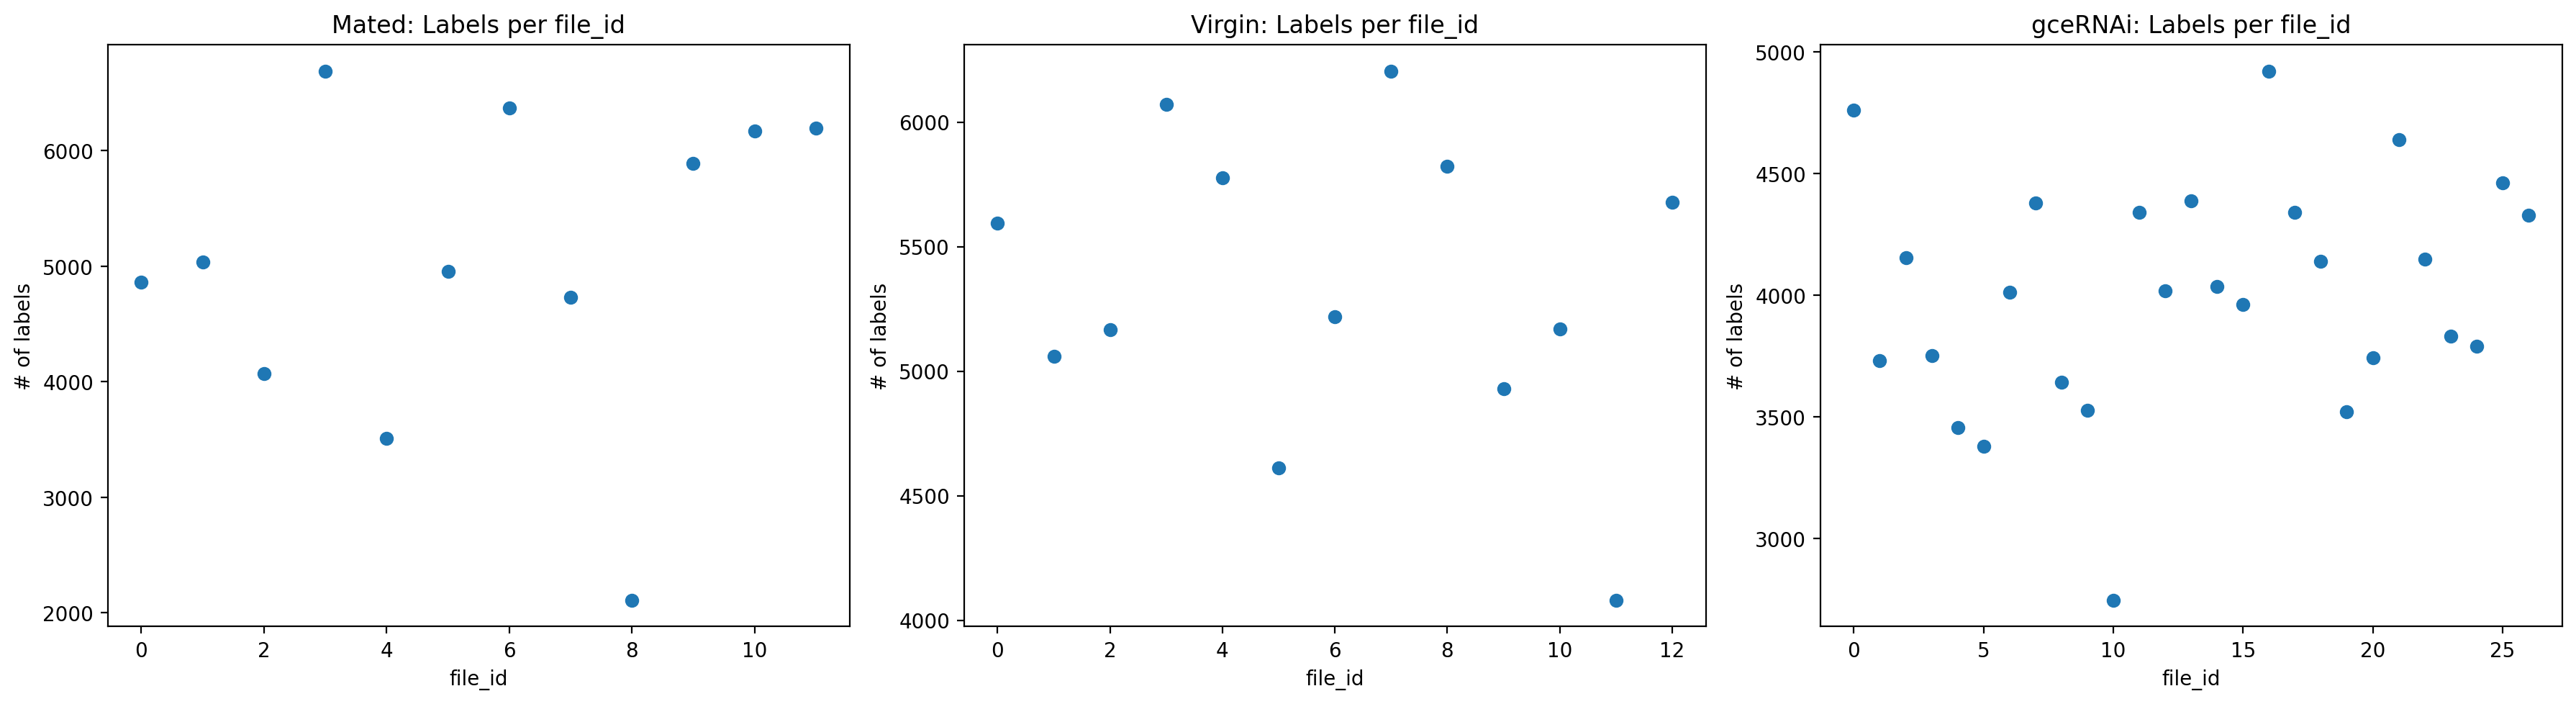

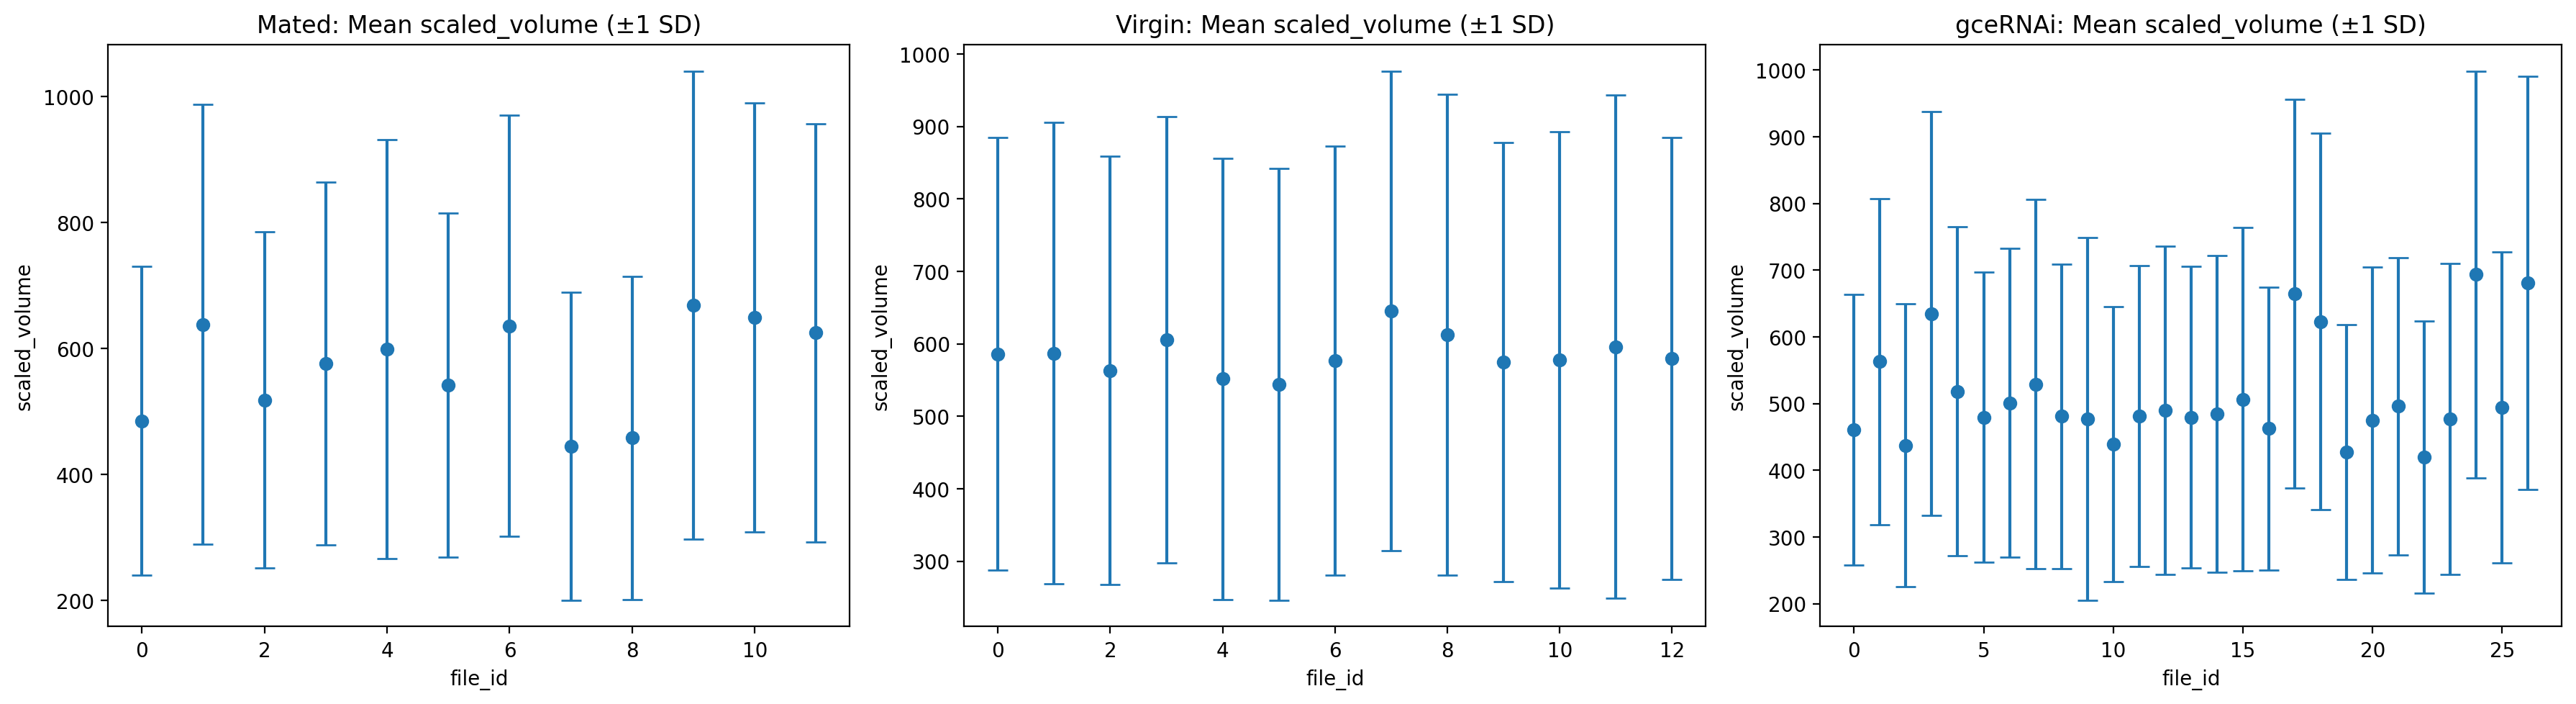

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Put all your dataframes in a list
dfs = [
    ("Mated", mated_10_df_high_low),
    ("Virgin", virgin_10_df_high_low),
    ("gceRNAi", gceRNAi_10_df_high_low)   
]
# -----------------------------
# 1️⃣ PLOT: Scatter — Number of labels per file_id
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for ax, (name, df) in zip(axes, dfs):
    counts = df.groupby("file_id")["label"].count()
    ax.scatter(counts.index, counts.values)
    ax.set_title(f"{name}: Labels per file_id")
    ax.set_xlabel("file_id")
    ax.set_ylabel("# of labels")

plt.tight_layout()
plt.show()

# -----------------------------
# 2️⃣ PLOT: Mean scaled_volume ± SD (with whisker caps)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for ax, (name, df) in zip(axes, dfs):
    stats = df.groupby("file_id")["scaled_volume"].agg(["mean", "std"])
    ax.errorbar(
        stats.index,
        stats["mean"],
        yerr=stats["std"],
        fmt='o',
        capsize=5     # <-- whisker ends
    )
    ax.set_title(f"{name}: Mean scaled_volume (±1 SD)")
    ax.set_xlabel("file_id")
    ax.set_ylabel("scaled_volume")

plt.tight_layout()
plt.show()


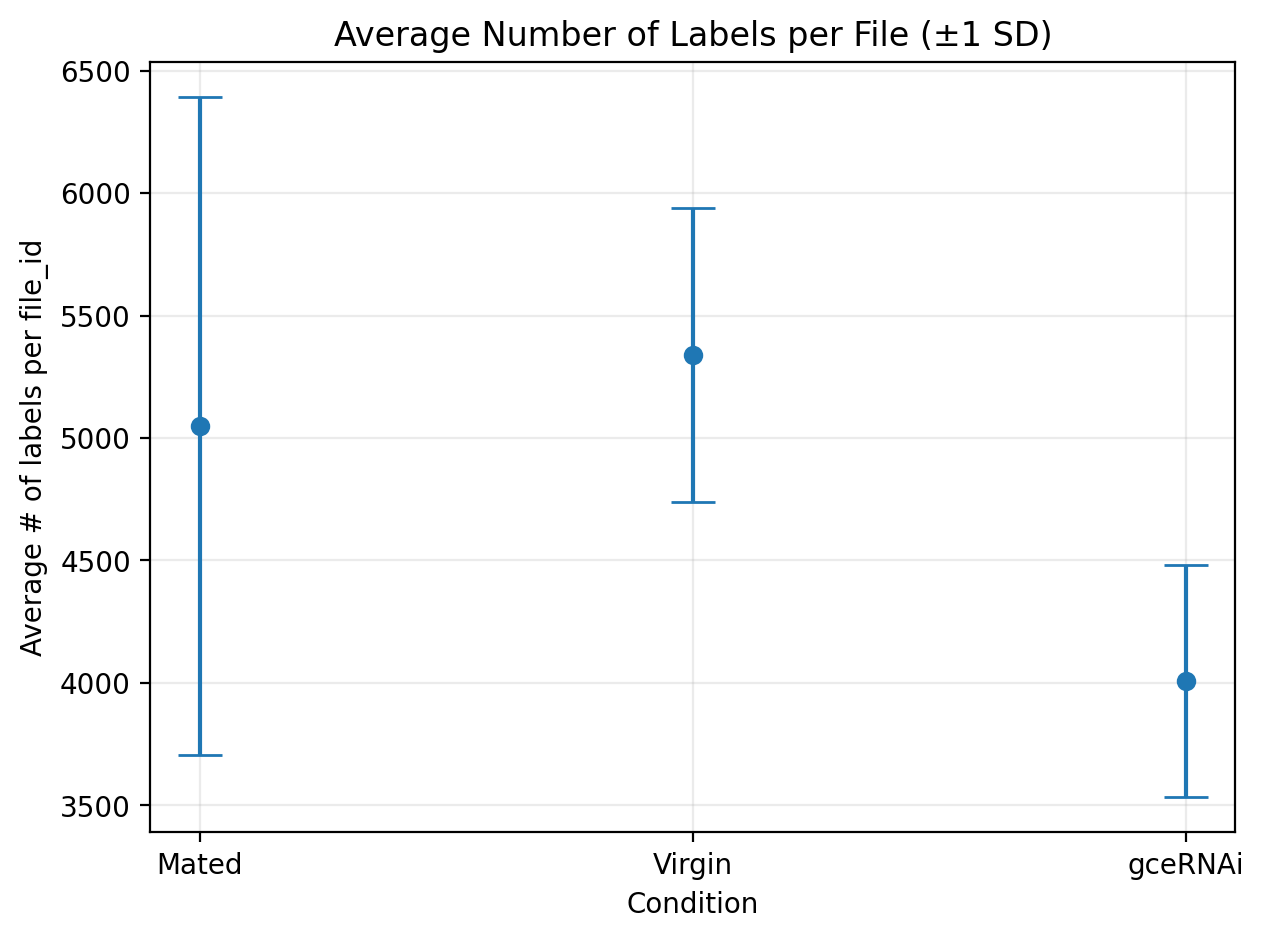

In [27]:
#I chucked this into chatgpt as it's 5:30:
import matplotlib.pyplot as plt
import pandas as pd

# Your three datasets
dfs = [
    ("Mated", mated_10_df_high_low),
    ("Virgin", virgin_10_df_high_low),
    ("gceRNAi", gceRNAi_10_df_high_low)  
]

# Compute mean ± SD of label counts per file_id
summary = []

for name, df in dfs:
    counts = df.groupby("file_id")["label"].count()
    summary.append({
        "condition": name,
        "mean_labels": counts.mean(),
        "std_labels": counts.std()
    })

summary_df = pd.DataFrame(summary)

# -----------------------------
# 📊 PLOT: Mean #labels with SD error bars
# -----------------------------
plt.figure(figsize=(7, 5))

plt.errorbar(
    summary_df["condition"],
    summary_df["mean_labels"],
    yerr=summary_df["std_labels"],
    fmt="o",
    capsize=8
)

plt.title("Average Number of Labels per File (±1 SD)")
plt.xlabel("Condition")
plt.ylabel("Average # of labels per file_id")
plt.grid(True, alpha=0.25)

plt.show()


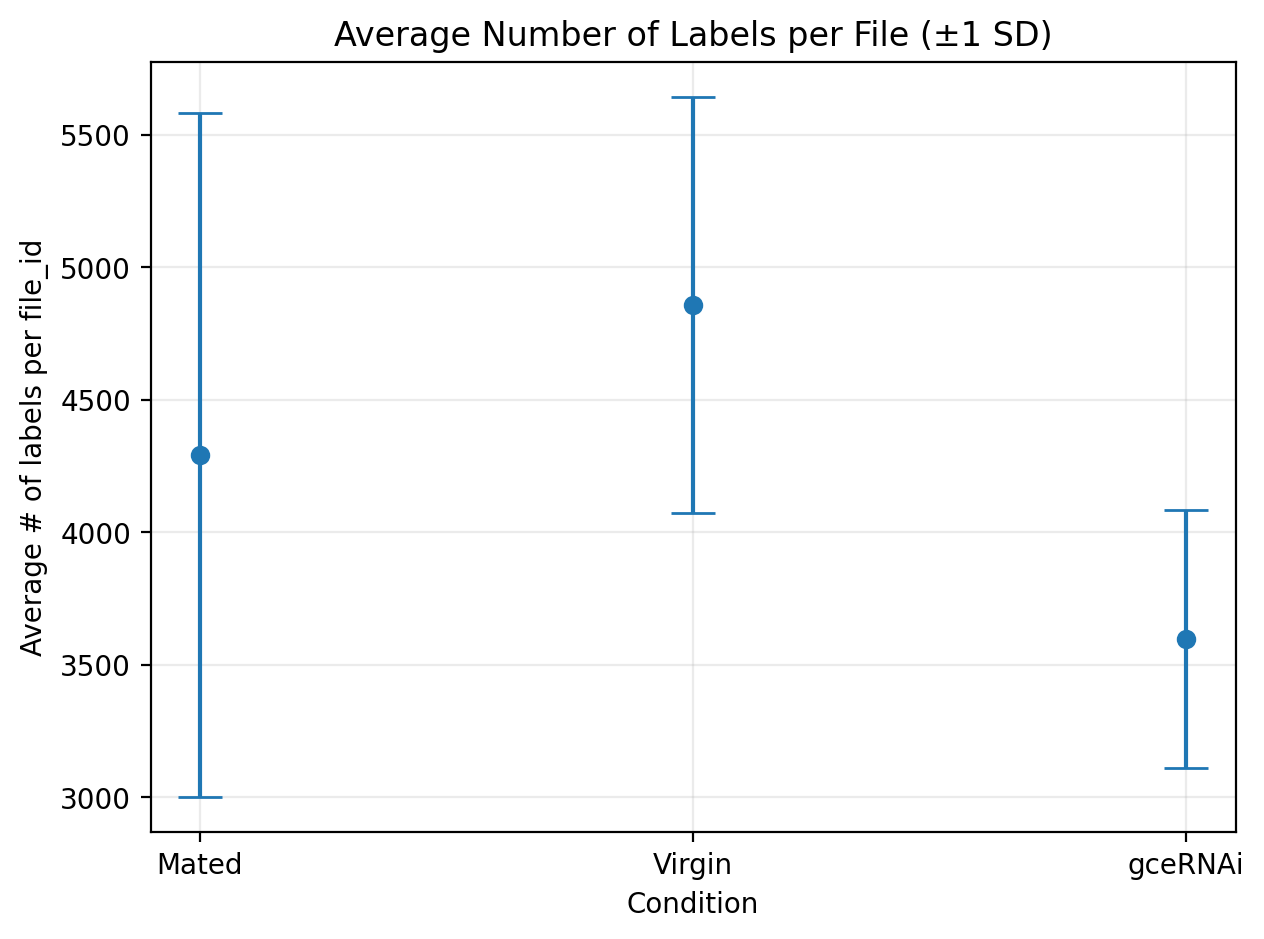

In [28]:
dfs = [
    ("Mated", mated_15_df_high_low),
    ("Virgin", virgin_15_df_high_low),
    ("gceRNAi", gceRNAi_15_df_high_low)  
]

# Compute mean ± SD of label counts per file_id
summary = []

for name, df in dfs:
    counts = df.groupby("file_id")["label"].count()
    summary.append({
        "condition": name,
        "mean_labels": counts.mean(),
        "std_labels": counts.std()
    })

summary_df = pd.DataFrame(summary)

# -----------------------------
# 📊 PLOT: Mean #labels with SD error bars
# -----------------------------
plt.figure(figsize=(7, 5))

plt.errorbar(
    summary_df["condition"],
    summary_df["mean_labels"],
    yerr=summary_df["std_labels"],
    fmt="o",
    capsize=8
)

plt.title("Average Number of Labels per File (±1 SD)")
plt.xlabel("Condition")
plt.ylabel("Average # of labels per file_id")
plt.grid(True, alpha=0.25)

plt.show()

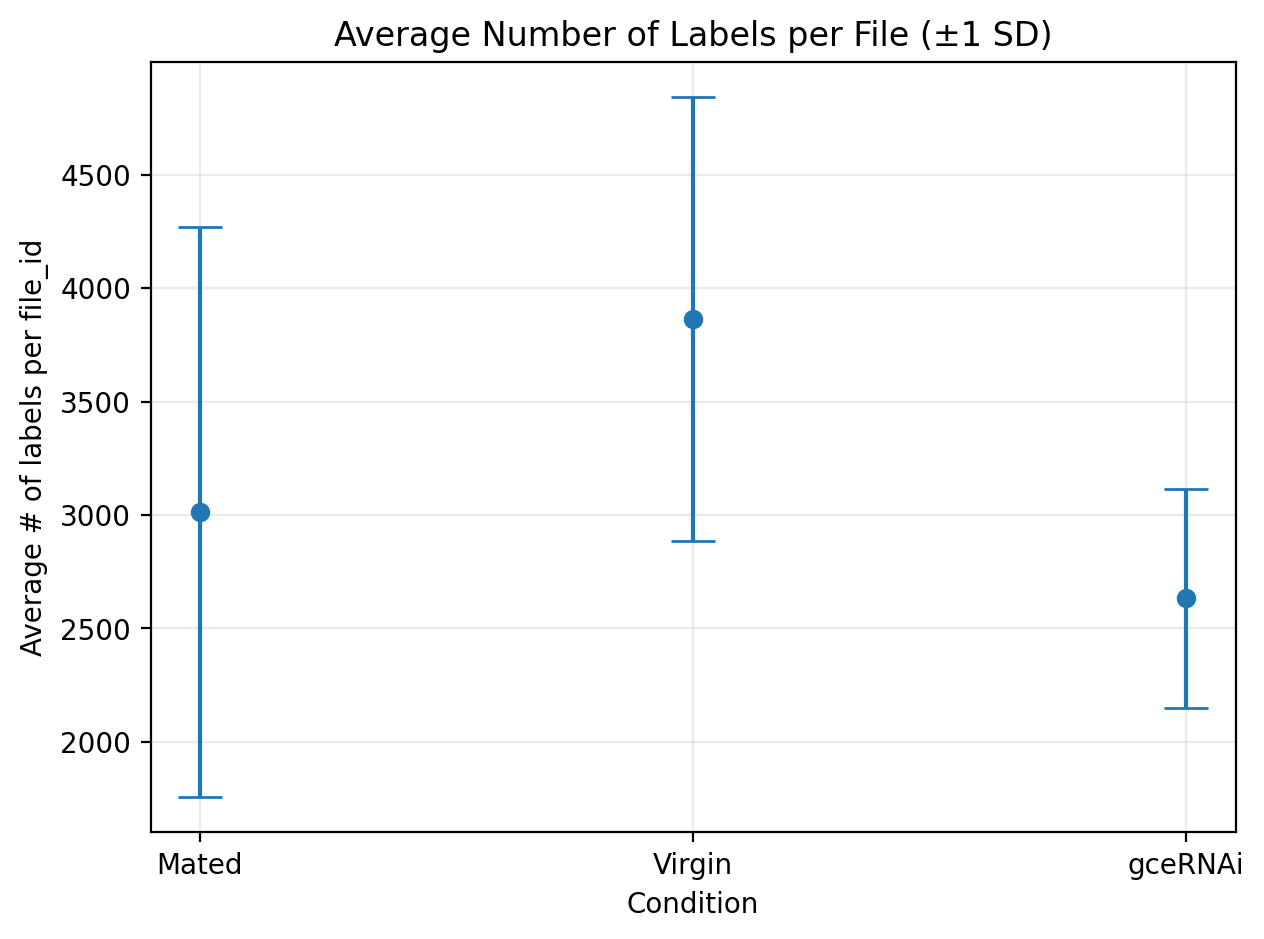

In [29]:
dfs = [
    ("Mated", mated_20_df_high_low),
    ("Virgin", virgin_20_df_high_low),
    ("gceRNAi", gceRNAi_20_df_high_low)  
]

# Compute mean ± SD of label counts per file_id
summary = []

for name, df in dfs:
    counts = df.groupby("file_id")["label"].count()
    summary.append({
        "condition": name,
        "mean_labels": counts.mean(),
        "std_labels": counts.std()
    })

summary_df = pd.DataFrame(summary)

# -----------------------------
# 📊 PLOT: Mean #labels with SD error bars
# -----------------------------
plt.figure(figsize=(7, 5))

plt.errorbar(
    summary_df["condition"],
    summary_df["mean_labels"],
    yerr=summary_df["std_labels"],
    fmt="o",
    capsize=8
)

plt.title("Average Number of Labels per File (±1 SD)")
plt.xlabel("Condition")
plt.ylabel("Average # of labels per file_id")
plt.grid(True, alpha=0.25)

plt.show()

In [30]:
##export a csv file with the number of cells per file, the average size of the cells and their standard devitation

def output_maker(condition_df):
    #this takes the data frame of one condition, and pixel size, and creates a csv file which is just how many cells are in each gut, their average size and std
    stats = condition_df.groupby("file_id").agg(
    filename=("filename", "first"),
    Total_Cells=("scaled_volume", "count"),
    Average_Size_um3=("scaled_volume", "mean"),
    Cell_Size_Std=("scaled_volume", "std")
    )
    return stats

In [31]:
output_df = output_maker(mated_10_df_high_low)

In [32]:
#list of all the dataframes
all_df = {
    "mated_10_df_high_low": mated_10_df_high_low,
    "mated_15_df_high_low": mated_15_df_high_low,
    "mated_20_df_high_low": mated_20_df_high_low,
    "virgin_10_df_high_low": virgin_10_df_high_low,
    "virgin_15_df_high_low": virgin_15_df_high_low,
    "virgin_20_df_high_low": virgin_20_df_high_low,
    "gceRNAi_10_df_high_low": gceRNAi_10_df_high_low,
    "gceRNAi_15_df_high_low": gceRNAi_15_df_high_low,
    "gceRNAi_20_df_high_low": gceRNAi_20_df_high_low,
}

In [33]:
for name, df in all_df.items():
    df_out = output_maker(df)
    df_out.to_csv(f"{save_dir}/{name}.csv", index=False)

In [34]:
save_dir


'/camp/home/fallest/Desktop/working/fallest/Projects/Ale_Mineo/Copy_Of_Datasets/Data_Out_Short_Names/'